### study2_answer_and_rubric_train_and_eval_v0.1
- 最終更新: 2023/8/6, 15:26

- 研究2: 回答+採点基準表モデルの学習/評価（研究1の全データ）

#### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.0 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.2-cp310-cp310-linux_x86_64.whl size=219143 sha256=cf961f25c16f6e88c1d7acae0e56a5bc5df8627ca0ddba1683b97623ed292cf0
  Stored in directory: /root/.cache/pip/wheels/bd/87/af/2a36d74f666a8428943b70d71c5e9dd740435bf671f210672c
Successfully built neologdn


In [ ]:
pip install accelerate -U

In [ ]:
#GPUの認識状況の確認
!nvidia-smi

Sun Aug  6 06:57:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 以下はコード

##### データの準備
- v0.2までは`data_basic`を使っていた（train/test splitのみ実施）


In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

In [ ]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os
RANDOM_STATE = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(RANDOM_STATE)

In [ ]:
#採点基準表のデータを読み込む→ただし、study2_rubric_train_and_evalから持ってくる
data_rubric = pd.read_csv('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_rubric_train_and_eval/data_train.csv')
data_rubric = data_rubric.rename(columns={"scoring_key": "answer"})
data_rubric = data_rubric.drop(columns=["level_0", "index"])

data_rubric

,word_pair,word1,word2,answer,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
611,美術館-墓,美術館,墓,楽しい,0,美術館[SEP]墓[SEP]楽しい
612,美術館-墓,美術館,墓,ネットワーク状,0,美術館[SEP]墓[SEP]ネットワーク状
613,美術館-墓,美術館,墓,2つの要素が一つになる,0,美術館[SEP]墓[SEP]2つの要素が一つになる
614,美術館-墓,美術館,墓,平坦なシート,0,美術館[SEP]墓[SEP]平坦なシート


In [ ]:
#採点基準表
print(len(data_rubric.word_pair.unique()))
print(data_rubric.word_pair.unique())

20
['鳥-飛行機' '剣-拳銃' 'みかん-ボール' '太陽-電球' '紙-葉っぱ' '山頂-針' '道-川' '愛-薬物' '山-障害物'
 '輪っか-ネックレス' 'なぞなぞ-迷宮' '時間-川' '会社-木' '酒場-教会' '理論-建物' 'ダイヤモンド -雪片' '記憶-牢獄'
 '結婚-合金' '思考-網' '美術館-墓']


In [ ]:
#回答データの学習
data_answer = pd.read_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230213_PreExp_SST_ClassifyAnswer_v5.1.csv")
data_answer

,order,trial_index,time_elapsed,cwid,StartTime,EndTime,rt,word_pair,answer,SHに基づく得点,SH：補足,PickedSample,Classification_ksm,Classification_oka,ageement,CR_ksm,CR_oka,FinalRating,Note_ksm,Note_oka
0,1,2,33223,275026,44928.92420,44928.92715,15459,鳥 - 飛行機,とぶもの,2,NaN,1,2.0,2,1.0,NaN,NaN,2,NaN,NaN
1,2,3,41046,275026,44928.92420,44928.92715,7810,剣 - 拳銃,攻撃するもの,1,攻撃するという共通点だけ,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
2,3,4,50740,275026,44928.92420,44928.92715,9687,みかん - ボール,球状,2,球状は球形の同義語,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
3,4,5,55109,275026,44928.92420,44928.92715,4346,太陽 - 電球,光る,2,NaN,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
4,5,6,60701,275026,44928.92420,44928.92715,5565,紙 - 葉っぱ,平たい,1,平たいシートである点がポイント、平たいは低次の共通点,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,21,204228,1052834,44929.48289,44929.48591,6198,結婚 - 合金,合わせる,2,NaN,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
1916,1917,22,231500,1052834,44929.48289,44929.48591,27269,思考 - 網,アメーバ状,2,v2で2点に変更,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
1917,1918,23,248260,1052834,44929.48289,44929.48591,16758,学位 - 橋,昇り詰める,1,そういう橋があるのは事実,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
1918,1919,24,256516,1052834,44929.48289,44929.48591,8254,美術館 - 墓,飾る,1,骨/ものを飾るか,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN


In [ ]:
#trial_indexで以下を除外
#Oka, Utsumi, & Kusumi (under review)では項目選定の都合で以下の項目についても利用していたが、最終的には利用しなかった。
#詳細はhttps://github.com/okaexp/Japanese_version_of_SST

#12: 孤独-砂漠
#20: 鍵-答え
#23: 学位-橋
#25: 若者-鳥

data_answer = data_answer[~data_answer["trial_index"].isin([12, 20, 23, 25])]
print(data_answer.trial_index.unique())
print(data_answer.word_pair.unique())
print(len(data_answer.trial_index.unique()))

[ 2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 24]
['鳥 - 飛行機' '剣 - 拳銃' 'みかん - ボール' '太陽 - 電球' '紙 - 葉っぱ' '山頂 - 針' '道 - 川'
 '愛 - 薬物' '山 - 障害物' '輪っか - ネックレス' 'なぞなぞ - 迷宮' '時間 - 川' '会社 - 木' '酒場 - 教会'
 '理論 - 建物' 'ダイヤモンド - 雪片' '記憶 - 牢獄' '結婚 - 合金' '思考 - 網' '美術館 - 墓']
20


In [ ]:
#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_answer = data_answer.loc[:, ["word_pair", "answer", "FinalRating"]]
data_answer = pd.concat([data_answer, data_answer['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_answer = data_answer.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_answer = data_answer.reindex(columns=["word1", "word2", "answer", "labels"])
data_answer

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,みかん,ボール,球状,2
3,太陽,電球,光る,2
4,紙,葉っぱ,平たい,1
...,...,...,...,...
1912,ダイヤモンド,雪片,美しい,1
1913,記憶,牢獄,覚える,0
1915,結婚,合金,合わせる,2
1916,思考,網,アメーバ状,2


In [ ]:
#data_basicからユニークな回答（word1ごとのanswerをユニークにする）を抽出する
#重複する回答はモデル学習/評価時にリークする恐れがあるため除外する
#ref: https://tiruka.hatenablog.jp/entry/2018/09/07/120553
data_answer_unique = data_answer.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_answer_unique

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,みかん,ボール,球状,2
3,太陽,電球,光る,2
4,紙,葉っぱ,平たい,1
...,...,...,...,...
1910,酒場,教会,のめり込む,1
1911,理論,建物,硬い,1
1913,記憶,牢獄,覚える,0
1916,思考,網,アメーバ状,2


In [ ]:
#なぜかword1/word2にスペースが混ざっているケースがあったので削除する
def remove_dumb_spaces(string):
  return string.rstrip().lstrip()

#data_rubricとdata_answer_uniqueの結合
data_answer_and_rubric = pd.concat([data_rubric, data_answer_unique])
data_answer_and_rubric = data_answer_and_rubric.reset_index()
data_answer_and_rubric["word1"] = data_answer_and_rubric["word1"].map(remove_dumb_spaces)
data_answer_and_rubric["word2"] = data_answer_and_rubric["word2"].map(remove_dumb_spaces)
data_answer_and_rubric = data_answer_and_rubric.drop(columns=["index", "word_pair"])

data_answer_and_rubric["text"] = data_answer_and_rubric['word1'] + "[SEP]" + data_answer_and_rubric["word2"] + "[SEP]" + data_answer_and_rubric["answer"]
data_answer_and_rubric

,word1,word2,answer,labels,text
0,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...
1830,酒場,教会,のめり込む,1,酒場[SEP]教会[SEP]のめり込む
1831,理論,建物,硬い,1,理論[SEP]建物[SEP]硬い
1832,記憶,牢獄,覚える,0,記憶[SEP]牢獄[SEP]覚える
1833,思考,網,アメーバ状,2,思考[SEP]網[SEP]アメーバ状


### 訓練データとテストデータの分割→予備調査全件を学習するので不要


In [ ]:
#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  data_all = data_all.reset_index()
  dataset_all = Dataset.from_pandas(data_all)
  dataset_all_encoded = dataset_all.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_all_encoded, data_all


# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self):
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(data_answer_and_rubric) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(data_answer_and_rubric) /len(data_answer_and_rubric.query('labels == 0')),
                                            len(data_answer_and_rubric) /len(data_answer_and_rubric.query('labels == 1')),
                                            len(data_answer_and_rubric) /len(data_answer_and_rubric.query('labels == 2'))]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()

def tokenize_basic(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

#### モデルの訓練と評価

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.054000,0.895163,0.633243,0.635439
2,0.888600,0.688388,0.675749,0.680875
3,0.734300,0.499799,0.826703,0.830969
4,0.582200,0.355920,0.862670,0.864668
5,0.458500,0.274570,0.863215,0.869119
6,0.379100,0.160965,0.948229,0.949009
7,0.290100,0.122911,0.950954,0.951844
8,0.233900,0.075896,0.982016,0.982145
9,0.184500,0.061562,0.983651,0.983709
10,0.146800,0.056729,0.984741,0.984795


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study2/study2_answer_and_rubric_train_and_eval/checkpoint-580


<ipython-input-19-e17450af1cac>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]


Map:   0%|          | 0/1309 [00:00<?, ? examples/s]

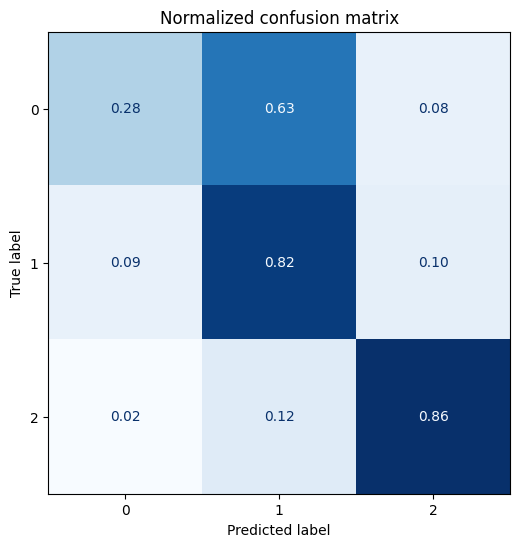

              precision    recall  f1-score   support

           2       0.34      0.28      0.31       120
           1       0.78      0.82      0.80       630
           0       0.87      0.86      0.87       559

    accuracy                           0.79      1309
   macro avg       0.67      0.65      0.66      1309
weighted avg       0.78      0.79      0.78      1309



In [ ]:
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study2/study2_answer_and_rubric_train_and_eval"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_answer_and_rubric_train_and_eval/"
BATCH_SIZE = 32

#config関数から呼び出し
cur_lc = load_config()
cur_config = cur_lc.return_config()

#モデルとトークナイザの初期化
model, tokenizer = load_bert_model_and_tokenizer()

#データセットの用意
dataset_all_encoded, data_all = create_dataset(data_answer_and_rubric)

#Trainerのconfig周り
#TrainingArgumentsの準備
#ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
#ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_strategy="epoch",#4/4まで; noにして, どうなるかを確認する->load_best_model_at_endと重複するからnoはダメらしい
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=cur_config["logging_steps"],
    push_to_hub=False,
    log_level="error",
    label_names=['labels'],
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Trainerの定義
trainer = CustomTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_all_encoded,
    eval_dataset=dataset_all_encoded,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# トレーニング実行
trainer.train()

#trainerのbestモデルの場所を書く
print("best model: ", trainer.state.best_model_checkpoint)

#モデルの保存を明示的に書く
trainer.save_model()

#評価する
#評価データの読み込み
data_eval = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230412_edited_dat_after_aggregate_v0.1.xlsx', sheet_name=0, index_col=None)
#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_eval = data_eval.loc[:, ["word_pair", "answer", "FinalRating"]]
data_eval = pd.concat([data_eval, data_eval['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_eval = data_eval.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_eval = data_eval.reindex(columns=["word1", "word2", "answer", "labels"])
data_eval_unique = data_eval.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]
data_eval_unique = data_eval_unique.dropna(subset=["word1", "word2"], how="all")
data_eval_unique["labels"] = data_eval_unique["labels"].astype(int)

data_eval_unique_reset_index = data_eval_unique.reset_index()
dataset_eval_unique_reset_index = Dataset.from_pandas(data_eval_unique_reset_index)
dataset_eval_unique_reset_index_encoded = dataset_eval_unique_reset_index.map(tokenize_basic, batched=True, batch_size=None)

preds_output = trainer.predict(dataset_eval_unique_reset_index_encoded)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(data_eval_unique_reset_index["labels"])
data_eval_unique_reset_index["pred"] = y_preds

#confusion_matrixの表示と保存
plot_confusion_matrix(data_eval_unique_reset_index["pred"], data_eval_unique_reset_index["labels"], RESULT_OUTPUT_DIR_BASE)

#classification_reportの表示と保存
categories = data_eval_unique_reset_index['labels'].unique().tolist()
categories = list(map(str, categories))
classification_report_txt = classification_report(y_valid, y_preds, target_names=categories)
print(classification_report_txt)

with open(RESULT_OUTPUT_DIR_BASE + "classification_report.txt", "w") as output_file:
  output_file.write(classification_report_txt)

data_all.to_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_answer_and_rubric_train_and_eval/data_train.csv", index=False)
data_eval_unique_reset_index.to_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_answer_and_rubric_train_and_eval/data_test.csv", index=False)